In [2]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys             
from sympy import *                                # Module to see files and folders in directories
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit
import pandas as pd
import os
from importlib import reload

sys.path.append('../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

sys.path.append('../Extra_External_Functions')
import EEF
reload(EEF)
from EEF import Datahandler

In [3]:
# Usefull functions
def acceptreject(func, xmin, xmax, ymin, ymax, N_points):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran)
    xkeep = xran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing)
    else:
        xrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaltries = N_points + tries
    return finalx, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points):
    x, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, tries, area, eff

def F_dis(dataset1, dataset2):
    var1 = np.var(dataset1, ddof = 1)
    var2 = np.var(dataset2, ddof = 1)
    if var1 > var2:
        F = var1/var2
    else:
        F = var2/var1
    print(F)

def student_t(dataset1, dataset2):
    mean1 = np.mean(dataset1)
    var1 = np.var(dataset1, ddof = 1) #Estimated var
    N1 = len(dataset1)
    mean2 = np.mean(dataset2)
    var2 = np.var(dataset2, ddof = 1) #Estimated var
    N2 = len(dataset2)
    S = np.sqrt(((N1-1)*var1 + (N2-1)*var2)/(N1+N2-2))
    t = (mean1 - mean2)/(S * np.sqrt(1/N1 + 1/N2))
    print(t)

def geterrors(z, symlist, vals, sigmas):    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

## Problem 1
#### (1.1)

In [4]:
# Two games of dice, each giving the player equal odds are played. 
# In the first game playedwith one dice, the player wins if getting one six in 4 rolls,
# while in the second game played withtwo die, the player wins if getting two sixes (at the same time) in 24 rolls (with two die).

# Part 1. Calculate the odds of winning in both games. Which game would you play, if either?

# Game 1. Use binomial mass function
notp1 = stats.binom.pmf(4, 4, 5/6)
p1 = 1 - notp1
print(p1) # p = 0.52

# Game 2 
notp2 = stats.binom.pmf(24, 24, 35/36)
p2 = 1 - notp2
print(p2) # p = 0.49

# The first game is worth playing, but the second is not. playing both in a row is also a bad idea as the chance of winning both is ~0.25

0.5177469135802468
0.49140387613090364


#### (1.2)

In [5]:
# The IceCube experiment has been running for 1730 days, 
# and has for a particular analysis found an average random background rate of 18.9 event per day.

# Part 1. What distribution should the daily number of (background) events follow?

# They should follow a possion distribution as it is distinged event which happend on a continues timeline.

# Part 2. If the experiment in a single day saw 42 events, would that signify a statistically significant excess?
# The survival function calculates the probability of getting 42 events or more as a more fair way of treating the question
pday = stats.poisson.sf(42, 18.9)
print(pday)
# And now we need to take into account the amount of obervations to do a poisson test.
ptotal1 = 1 - stats.binom.pmf(1730,1730,1-pday)
ptotal2 = stats.binom.sf(0, 1730, pday)
ptotal3 = 1 - (1-pday)**1730
print(ptotal1, ptotal2, ptotal3)
# The probability of getting 42 or more events during a day one or more times during 1730 days of observation is only 0.002 which is too low to be a statistical anormally within a 1% significance interval


1.3718502458083341e-06
0.002370488497392964 0.002370488497294431 0.0023704884973593243


#### (1.3)

In [6]:
# Assume that the height of Danish women follows a 
# Gaussian distribution with a mean of 1.68 m and a standard deviation of 0.06 m

# Part 1. What fraction of women are taller than 1.85 m?
mu = 1.68
sigma = 0.06
print((1.85-mu)/sigma)
p = stats.norm.sf(1.85, mu, sigma)
print(p)
# only 0.002 of women are taller than 1.85

# Part 2. Find (possibly numerically) the average height of the 20% tallest women?

# for i in np.linspace(1.85, 1.68, 10000):
#     if stats.norm.sf(i, mu, sigma) > 0.2:
#         print(i)
#         print(stats.norm.sf(i, mu, sigma))
#         break
# Analysis show that the 20% tallest women are 1.7305 m or higher
# We can then do monte carlo to get the mean
r = np.random
def acceptreject(func, xmin, xmax, ymin, ymax, N_points):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran)
    xkeep = xran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing)
    else:
        xrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaltries = N_points + tries
    return finalx, finaltries

def top20gauss_pdf(x):
    return 5 * stats.norm.pdf(x, mu, sigma)

N_points = 100000
xmin = 1.7305
xmax = 2.3
ymax = 23.33
ymin = 0
xarray, tries = acceptreject(top20gauss_pdf, xmin, xmax, ymin, ymax, N_points)
print(np.mean(xarray))
# print(tries)
# The mean of the 20 % women is 1.764 cm


2.833333333333336
0.002303266131695864
1.7639429525678303


## Problem 2
#### (2.1)

In [7]:
# The resistance of a cylindrical resistor is proportional to the length L, 
# and inversely proportional to the cross sectional area A = πr**2

# Part 1. What should the relation between the relative uncertainties on L and r be 
# for them to contribute equally to the uncertainty on the resistance

# So R = C * L/πr**2
# So the variance contribution to R has to be the same

CSym, LSym, rSym = symbols("C L r")
R = CSym * LSym / (np.pi * rSym**2)
print(R.diff(LSym)**2, R.diff(rSym)**2)
# So I understand relative uncertainty as some procentage times the value. so sigmaL = L * sigmaL_p
# (1/pi)**2 * C**2 / r**4 * L**2 * sigmaL_p**2 = (-2/pi)**2 * C**2 * L**2 / r**6 * r**2 * sigmar_p**2
# sigmaL_p**2 = 4 * sigmaR_p**2 <=> sigmaL_p = 2 * simgar_p
# The relative error on L needs to be 2 times as large as on r


0.101321183642338*C**2/r**4 0.405284734569351*C**2*L**2/r**6


#### (2.2)

In [8]:
results = np.array([3.61, 2.00, 3.90, 2.23, 2.32, 2.48, 2.43, 3.86, 4.43, 3.78])*100
bulletmean = np.mean(results)
bulletstd = np.std(results)
bulleteom = np.std(results, ddof = 1)/np.sqrt(93)
print(bulletmean, bulletstd, bulleteom)

def geterrors(z, symlist, vals, sigmas):    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

mass = 8.4/1000
sigmamass = 0.5/1000
kin, sigmakin = geterrors((mass, bulletmean), (sigmamass, bulleteom))
print(kin, sigmakin)
# The kinetic energy in J is 400 +/- 80
# If I assume that more measurement does not change the std or mean the additional measurements only change the erro on the mean.
# The error needs to be reduced by about sqrt(10) which means 10 times the measurements or 100. 
# The precise number of measurement to get them as close as possible is 93


310.4 84.36492162030378 9.221449205413903


TypeError: geterrors() missing 2 required positional arguments: 'vals' and 'sigmas'

## Problem 3
#### (3.1)

0.24280841785851812
28.588458271191783 0.24280841785851812
1.0007013591520242
10.830723896695472


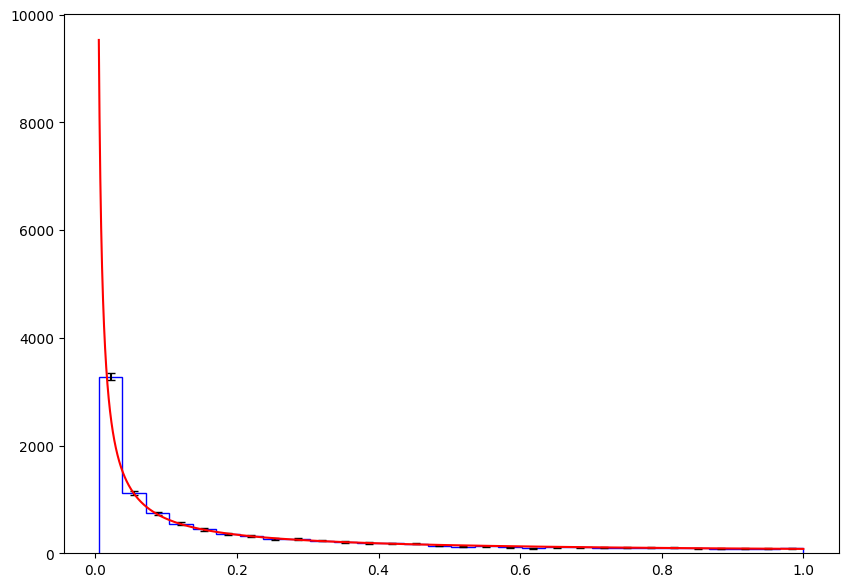

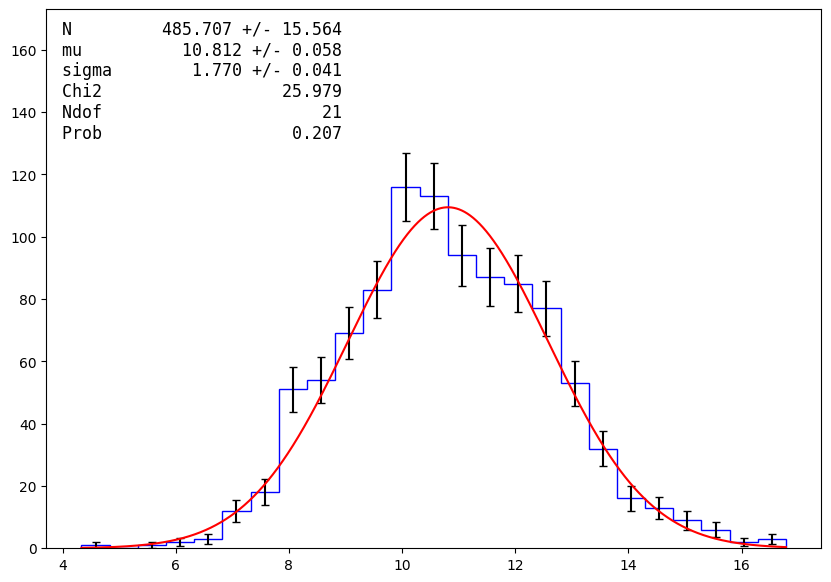

In [9]:
# Let f(x) = C * x**(−0.9) be proportional to a PDF for x ∈[0.005,1].

# Part 1. In order to fulfill the normalization criteria of a PDF, what value should C have?
xmin = 0.005
xmax = 1
N_points = 10000
intbinwidth = (xmax-xmin)/N_points
x = np.linspace(xmin, xmax, N_points)
def fx_unnorm(x):
    return x**(-0.9) * intbinwidth
integral = np.sum(fx_unnorm(x))
C = 1/integral
print(C)
def fx(x):
    return C * x**(-0.9) 

# Part 2. What method would you use to produce random numbers according to f(x)? Why?
# What would your answer be, if the allowed range was x ∈[0,1]?
print(fx(0.005), fx(1))
# I would always use accept reject as it is the easiest to compute. 
# If the interval started at 0, the only method is to do integration and inversion as ymax goes to infinity

# Part 3. Produce 10000 random numbers distributed according to f(x) and plot these.
ymin = fx(ymax)
ymax = fx(xmin)
data, tries, area, _ = acceptrejectdata(fx, xmin, xmax, ymin, ymax, N_points)
print(area)
print(np.mean(data)*50)
test = Datahandler(data, bins = 30)
test.initplot()
test.quickplot()
plt.plot(x, fx(x)*N_points/30, color = "r")
plt.show()
# Part 4. Let t be a sum of 50 random values from f(x), and generate 1000 values of t. Do they follow a Gaussian distribution?
#  And does their mean match the analytical expectation?
N_runs = 1000
sums = np.zeros(N_runs)
N_points = 50
for idx in range(N_runs):
    data, _, _, _ = acceptrejectdata(fx, xmin, xmax, ymin, ymax, N_points)
    sums[idx] = np.sum(data)

bins = 25
def fitgauss(x, N, mu, sigma):
    return N * stats.norm.pdf(x, mu, sigma)

data2 = Datahandler(sums, bins)
data2.initplot()
data2.quickplot()
_, _ = data2.chi2fit(fitgauss, N = 20, mu = 11, sigma = 1)
data2.plotfit()
plt.show()

# Test if the expected mean is the same as the obtained mean

## Problem 4
#### (4.1)

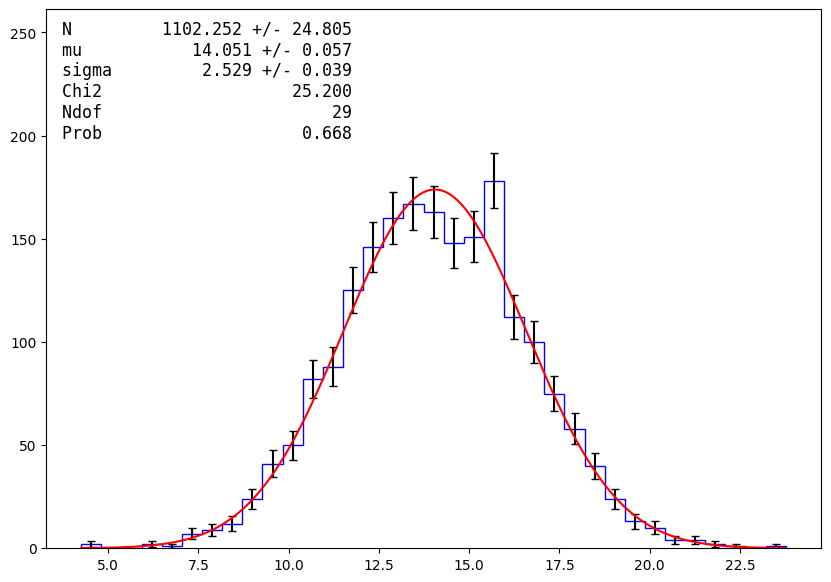

[[ 1.         -0.38827115]
 [-0.38827115  1.        ]]


In [10]:
# Medical scientists are working hard to develope a cure for the dreaded Fisher Syndrome, 
# a rare but debilitating condition that causes severely reduced ability to enjoy statistics problems. 
# Preliminary research indicates that the disease may be correlated to levels of substances (A, B, and C) in the blood. 
# Data with the levels of these substances from 3000 healthy (index 0) and 2000 ill (index 1) people.

# Part 1. What distributions does A seem to follow for ill people? Quantify your statements.

data = pd.read_csv("./data_FisherSyndrome.txt", names=["health", "A", "B", "C"], sep="\s+", index_col=1)
healthy = data[data["health"] == 0].iloc[:, 1:]
ill = data[data["health"] == 1].iloc[:, 1:]
# display(healthy)
# display(ill)

def fitgauss(x, N, mu, sigma):
    return N * stats.norm.pdf(x, mu, sigma)

N_bins = 35
healthyA = Datahandler(ill["A"].to_numpy(), N_bins)
healthyA.initplot()
healthyA.quickplot()
healthyA.chi2fit(fitgauss, N = 100, mu = 12.5, sigma = 2)
healthyA.plotfit()
plt.show()

# Part 2

BCcorr = np.corrcoef(ill["B"].to_numpy(), ill["C"].to_numpy())
print(BCcorr) #-0.38827115



In [11]:
# Part 3. WIP


## Problem 5
#### (5.1)

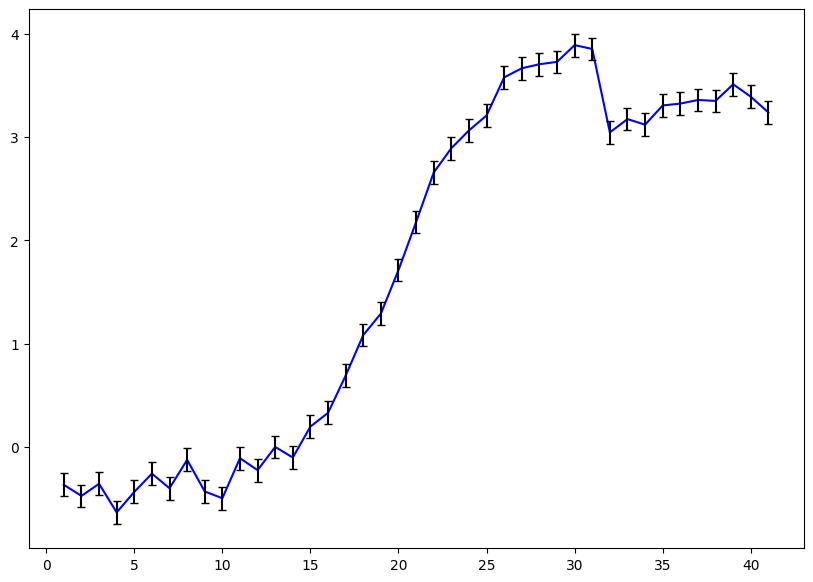

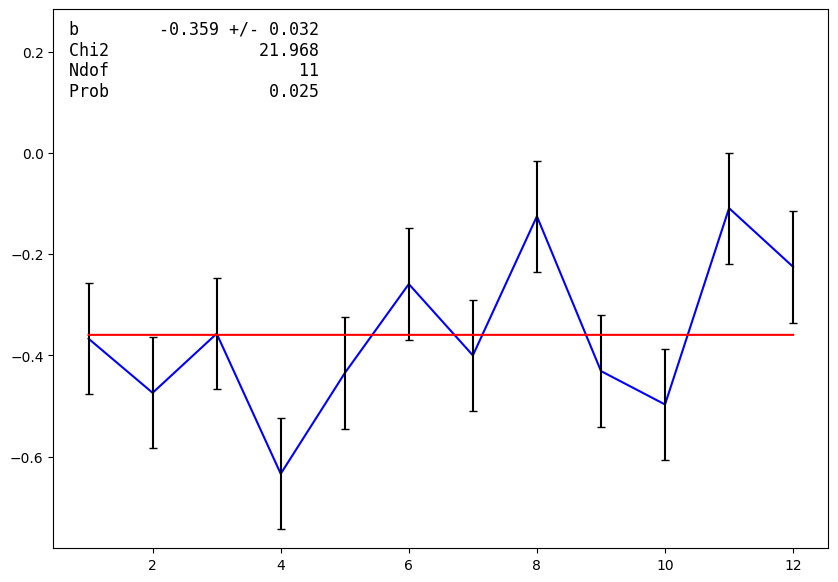

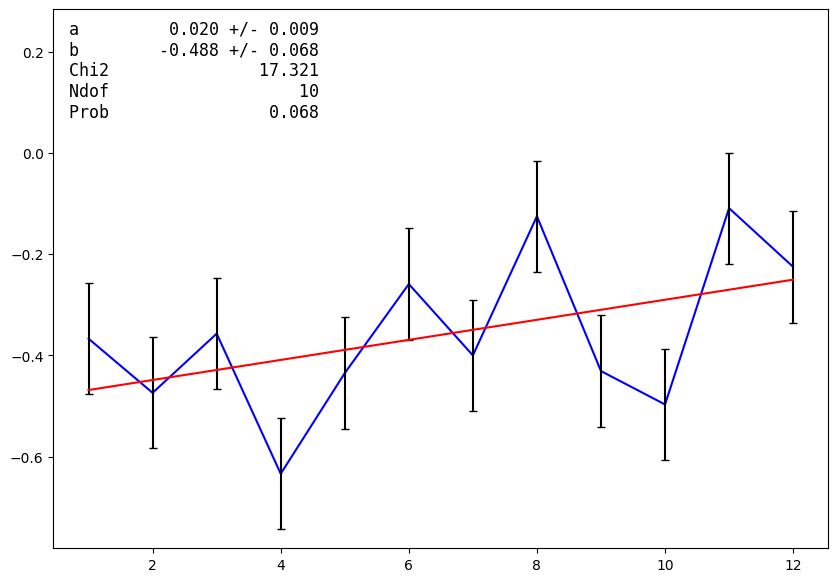

16


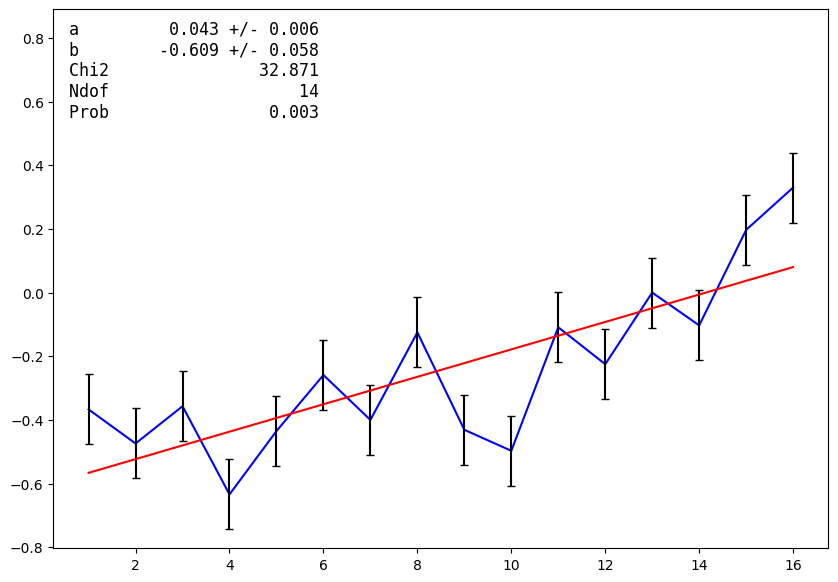

In [12]:
# Luke Lightning Lights is a manufacturer of solar powered flashlights. 
# Their monthly income since startup y (in M$) has been recorded as a function of month x in the filewww.nbi.dk/∼petersen/data LukeLightningLights.txt. 
# The uncertainty on y has been estimated by the accountantto be σy = 0.11 M$.

data = pd.read_csv("./data_LukeLightningLights.txt", names=["month", "", "income", "error"], sep="\s+")
data = data.drop("", axis = 1)
data2 = Datahandler(data.iloc[:,:].to_numpy().T, binneddata=False)
data2.initplot()
data2.quickplot()
plt.show()
# display(data)
data2 = Datahandler(data.iloc[:12,:].to_numpy().T, binneddata=False)
data2.initplot()
data2.quickplot()
def fitfunc1(x, b):
    return np.ones_like(x) * b
data2.chi2fit(fitfunc1, b = -0.3)
data2.plotfit()
plt.show()

# Part 2.

data2.initplot()
data2.quickplot()
def fitfunc2(x, a, b):
    return a * x + b
data2.chi2fit(fitfunc2, a = 0.1, b = -0.7)
data2.plotfit()
plt.show()
for i in range(12, len(data)):
    data2 = Datahandler(data.iloc[:i,:].to_numpy().T, binneddata=False)
    _, _, _, _, prob = data2.chi2fit(fitfunc2, a = 0.02, b = -0.5, fulldata=True)
    if prob < 0.01:
        print(i)
        data2.initplot()
        data2.quickplot()
        data2.plotfit()
        plt.show()
        break


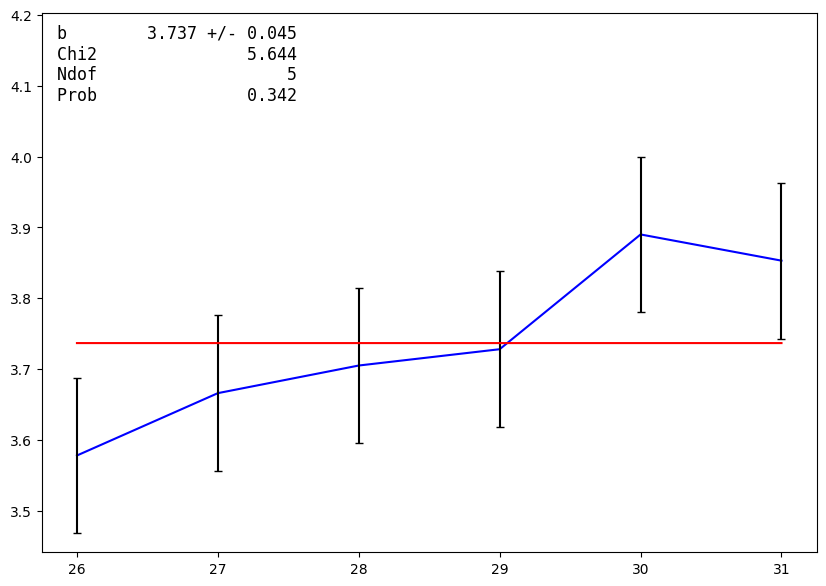

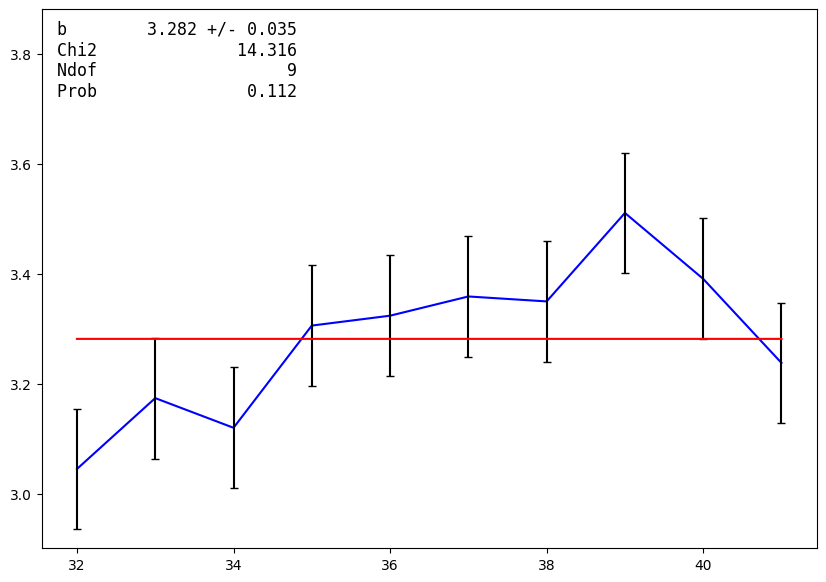

[0.00201667 0.00121   ]
-0.4548666667531607 0.05680375575719839
[ 4.19462603 19.76284723  2.53140793 -0.40252308]


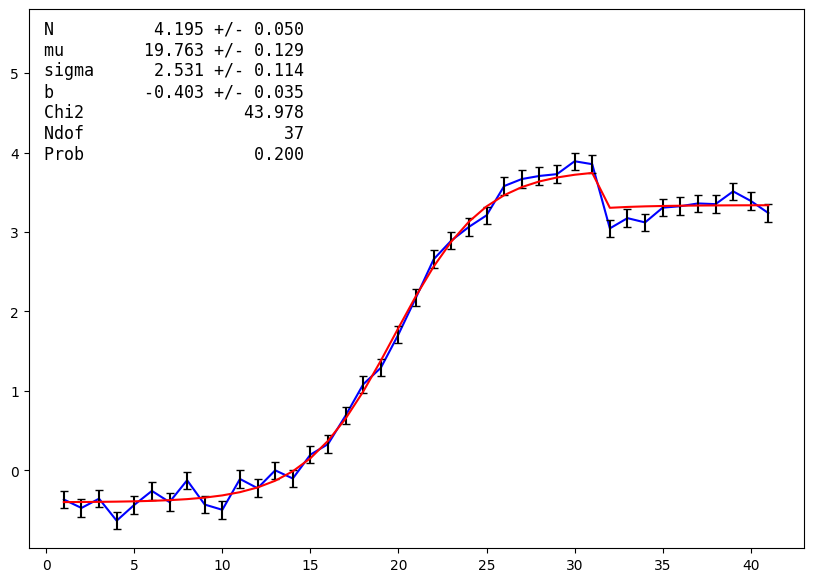

In [13]:
# Part 3

before = Datahandler(data.iloc[25:31,:].to_numpy().T, binneddata=False)
after = Datahandler(data.iloc[31:,:].to_numpy().T, binneddata=False)
before.initplot()
before.quickplot()
b_values, b_errors = before.chi2fit(fitfunc1, b = 3.8)
before.plotfit()
plt.show()
after.initplot()
after.quickplot()
a_values, a_errors = after.chi2fit(fitfunc1, b = 3.8)
after.plotfit()
# after.chi2fit(fitfunc2, a = 0.2, b = 1)
# after.plotfit()
plt.show()

a, b = symbols("a b")
symlist = (a, b)
z = b - a
val, sigma = geterrors(z, symlist, (float(b_values), float(a_values)), (float(b_errors), float(a_errors)))
print(val, sigma) 

# a = 0
# b = 0
def fitfunc3(x, N, mu, sigma, b):
    def fx(x):
        return N * 1/(1 + np.exp(-(x-mu)/sigma)) + b
    x1 = x[:31]
    x2 = x[31:]
    y1 = fx(x1)
    y2 = fx(x2) + val
    y = np.append(y1, y2)
    # print(y)
    return y
total = Datahandler(data.to_numpy().T, binneddata = False)
total.initplot()
total.quickplot()
values, _ = total.chi2fit(fitfunc3, N = 4, mu = 20, sigma = 1, b = 0.5)
print(values)
total.plotfit(N_plotpoints = 41)
# xline = np.linspace(1, 41, 41)
# plt.plot(xline, fitfunc3(xline, *values))
plt.show()

#### (5.2)

Data has 1726 entries with the mean = 0.000 +/- 0.002 and std = 0.088


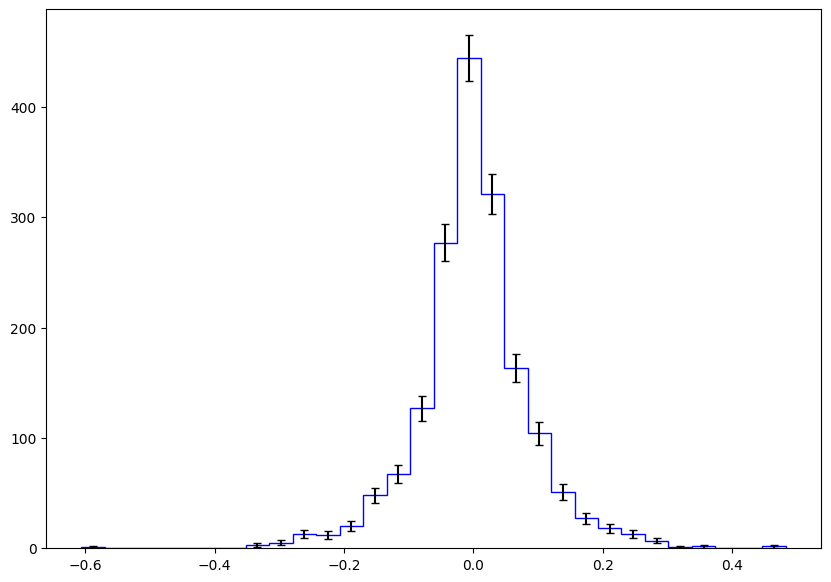

Data has 1721 entries with the mean = -0.000 +/- 0.002 and std = 0.084
!!! Fit did not converge !!!
!!! Give better initial parameters !!!


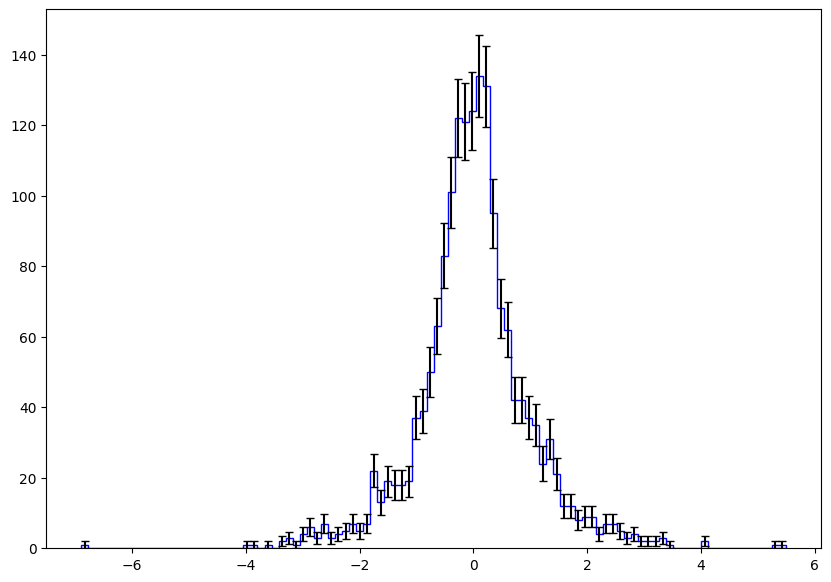

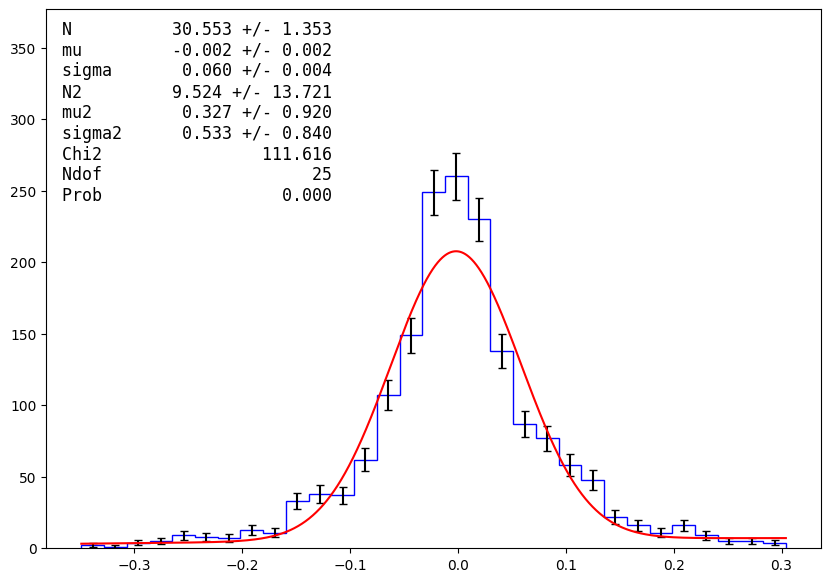

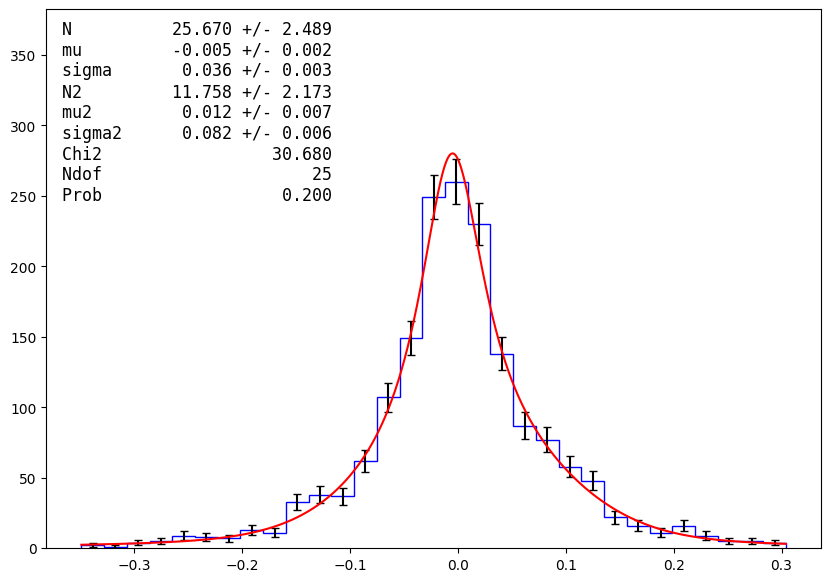

In [26]:
# A class of students have been timing a pendulum, 
# and the residuals of these time measurements in seconds can be found

# Part 1. 
# What is the typical timing uncertainty on one single measurement? 
# And is the mean of the residuals consistent with zero?
residuals = pd.read_table("./data_TimingResiduals.txt", names = ["residuals"]).to_numpy().T.flatten()
bins = 30
res = Datahandler(residuals, bins)
_, mean, std, eom = res.basicinfo()
res.initplot()
res.quickplot()
plt.show()
# Yes the mean is consistent with the expectation that it is 0

# Part 2. Based on the above answers and the size of the sample, do you find any of the residuals suspicious?
def z(x):
    return (x - mean)/std
zres = z(residuals)
zs = Datahandler(zres, 100)
zs.initplot()
zs.quickplot()

residuals = residuals[np.logical_and(zres > -4, zres < 4)]
def gauss_pdf(x, N, mu, sigma, N2, mu2, sigma2):
    return N * stats.norm.pdf(x, mu, sigma) + N2 * stats.norm.pdf(x, mu2, sigma2)
res2 = Datahandler(residuals, bins+1)
_, mean2, std2, eom2 = res2.basicinfo()
res2.initplot()
res2.quickplot()
res2.chi2fit(gauss_pdf, N=30, mu = 0, sigma = 0.1, N2=10, mu2 = 0, sigma2 = 1)
res2.plotfit()
plt.show()
def cauchy_pdf(x, N, mu, sigma, N2, mu2, sigma2):
    return N * stats.cauchy.pdf(x, mu, sigma) + N2 * stats.norm.pdf(x, mu2, sigma2)
res2.initplot()
res2.quickplot()
res2.chi2fit(cauchy_pdf,  N=30, mu = 0, sigma = 0.1, N2=10, mu2 = 0, sigma2 = 0.1)
res2.plotfit()
plt.show()